# CITS5553 Data Capstone Project
## Classifying Mineral Grains Using Data Science
### Peter Millitz (Student No. 23088298)
### Date: 22 Oct 2023    


## 1. Introduction

Portable Spectral Services (PSS) are a provider of in-house sampling services using various spectral technologies including micro-XRF (X-ray Fluorescence). PSS analyse samples typically in the form of mineral grains submitted by mining companies seeking to identify the precise mineral content of samples which is critical for mineral exploration but also essential for mine planning and production. In seeking to improve their capabilities, PSS had tasked the UWA Data Science Capstone Project, G8 project team, of which this author was a member, to investigate and evaluate a data science solution to the classification of mineral grains. In particular, they required that the solution must:

1. *Be rapid, accurate and precise*
2. *Quantify uncertainty in terms of a prediction probability*
3. *Identify both the critical and obsolete components of the classification*

The Mineral grains dataset, as supplied, comprised 8327 individual files or samples in tabular (CSV) format with each sample containing anywhere between 6160 to 12210 labelled spectra (rows) and each spectrum (observation) comprised of 4096 channels (columns), each recording radiation count rates for a specific energy window. Additional columns included sample grid location (X-Y coordinates), a total counts column ('Sum') and the 'Mineral Phase' label in the last column.

An analysis of the dataset identified the following key characteristics:

* **Large data volume**: more than 63 million observations of 51 unique mineral labels, a total size on disk of 497 GB
* **High-dimensionality**: 4097 columns i.e., features (4096 channels plus 'Sum')
* **Sparsity**: a significant number of columns contained zero values
* **Class imbalance**: the top nine classes (labels) had over 1 million counts each in contrast to the lowest five which had 50 or less counts each. 
* **Missing data**: 1320 samples (almost 16% of the entire dataset) found to have one or two columns missing ('Ch_4095' and 'CH_4096').

The primary objective adopted here was part of a broader group strategy whereby various Data Science techniques were employed and a diverse range of ML/DL models constructed, trialled and evaluated by the team in order to gain insight into the most feasible and practical solution to the current problem. Specifically, the author's contribution was an endevour to construct a machine learning model that was robust, easily interpretable and which established a baseline classifier that met all of the projects requirements whilst attempting to meet or exceeded the current misclassification rate achieved by existing PSS semi-automated workflows.

The algorithm chosen to meet this challenge was the Python scikit-learn linear model *SGDClassifier* class which implements regularised logistic regression with Stochastic Gradient Descent (SGD) learning. This particular classifier algorithm was chosen by the author because it is capable of multi-class output with prediction probabilities for each class label. The regulariser is a penalty added to the loss function that shrinks model coefficients to zero, using in this case the absolute norm L1, which allows for learning sparse models and achieving online feature selection. The algorithm also returns the model weights as an attribute and provides a method for out-of-core learning.

A separate pre-processing pipeline jupyter notebook "*mineral_preprocessing.ipynb*" deals with the issues of class imbalance, missing data and dimensionality reduction.

## 2. Methodology

The size of the dataset posed an immediate practical constraint on model design and training capacity. For initial testing, it was decided to focus on just the top five most frequently occuring minerals to demonstrate proof of concept (later expanded to 10 and 23 minerals). Preliminary testing indicated the optimal number training samples was around 10000 observations per mineral which was consistent with the experience of some others in the team. A series of bash scripts were written to to randomly 'harvest' 10000 observations for each of the five minerals from the entire dataset and to concatenate these observations into a single file for the next stage of pre-processing.

The raw concatenated file was then fed into a separate jupyter notebook for processing in Python. The purpose of this stage was to (i) detect and fill missing values (ii) remove unused and redundant columns (as advised by the client) and (iii) to check for the correct minerals and to balance the number of observations per mineral if this had not been done in the first stage. The processed file was then exported (with "proc" suffix) ready for the model construction and training phase (this notebook). 

The processed input file prepared for this instance of the notebook comprises a random sample of the top 10 most frequently occurring minerals with 13000 randomly selected observations per mineral and is based on a common training set used amongst the team. After loading the file, it was examined and analysed with brief statistical descriptions displayed.

The next stage involved preparing the training and test sets using a random split ratio of 80:20. 
The training features (X_train) were then standardised (centred and scaled). The same scaler transform was then applied to the test feature set (X_test).
 
The modelling phase began with a 3-fold cross-validated grid search of optimal hyperparameters for the model. In this case, 'alpha' which controls the degree of regularisation (the higher the value, the stronger the regularization) and 'max_iter' which is the maximum number of passes over the training data (aka epochs). The search was conducted in two passes, one pass holding alpha fixed while fitting a range of max_iter and the second pass fixing max_iter and varying alpha. The model was then trained using the resulting optimal hyperparameters.

Once fitted, the model outputs (classes, model weights) were examined/visualised and exported in an appropriate format (.csv file or .png image file). A formal evaluation of the model was then conducted on the basis of 3-fold cross-validated predictions generated on the training data with a confusion matrix and classification performance report summarising the results. Prediction probabilities were also generated and exported along with the mineral predictions for each observation (both as .csv files). 

Predictions and prediction probabilities were then generated (and exported) on the hitherto unseen (balanced) test data set and similar performance metrics generated.

Finally, the model was used to predict the minerals on an arbitrary, unbalanced and randomly selected data set (a standard test set used by all members of the team). All outputs were exported and the perfomance metrics produced in the usual manner.

## 3. Application and Results

### 3.1 Setup and configuration

#### 3.1.1 Load common libraries and settings

In [1]:
import pandas as pd
import numpy as np
import time
import os

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler

from IPython.core.display import Markdown

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# Where to save the figures
#PROJECT_ROOT_DIR = "."
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
#os.makedirs(IMAGES_PATH, exist_ok=True)

#### 3.1.2 Data repository access

In [2]:
os.access("G:/Modelling", os.F_OK)

True

### 3.2 Load and  examine the pre-processed dataset

**Note**: Input files loaded into this notebook are assumed to have been pre-processed. A separate Python Notebook ("*minerals_pre-processing.ipynb*") is provided for this purpose.

#### 3.2.1 Load the pre-conditioned dataset

In [3]:
# Load the csv formatted file
pss = pd.read_csv("G:/Modelling/FINAL_PROCESSED/top10_13K_final_proc.csv")

#### 3.2.2 Examine and display statistics or the pre-conditioned dataset

In [4]:
# Print the first few lines of the raw data
pss.head()

,CH_121,CH_122,CH_123,CH_124,CH_125,CH_126,CH_127,CH_128,CH_129,CH_130,...,CH_2492,CH_2493,CH_2494,CH_2495,CH_2496,CH_2497,CH_2498,CH_2499,CH_2500,Mineral Phase
0,1,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Amphibole
1,0,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,Amphibole
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Amphibole
3,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,1,Amphibole
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,Amphibole


First three columns omitted. Channel columns outside the range [121, 2500] have been dropped (based on client advice). 'Sum' column also dropped.

In [5]:
# Display dataset structure
pss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Columns: 2381 entries, CH_121 to Mineral Phase
dtypes: int64(2380), object(1)
memory usage: 2.3+ GB


In [6]:
# Check dataset balance - list all mineral labels and observations per mineral
mineral_groups = pss.groupby('Mineral Phase').size()
mineral_groups

Mineral Phase
Amphibole      13000
Background     13000
Epidote        13000
Fe-Oxide       13000
Fe-Silicate    13000
Ilmenite       13000
Monazite       13000
Rutile         13000
Titanite       13000
Zircon         13000
dtype: int64

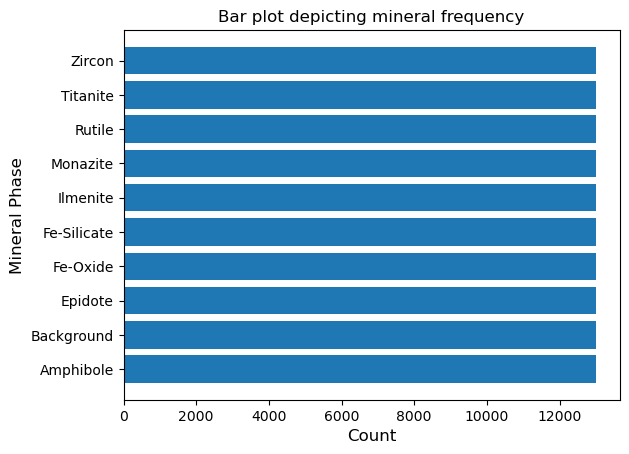

In [7]:
# Visual check

# Sort the grouped data by count in ascending order (bottom up)
mineral_groups = mineral_groups.sort_values(ascending=True)

# Create a horizontal bar plot
plt.barh(mineral_groups.index, mineral_groups.values)

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Mineral Phase')
plt.title('Bar plot depicting mineral frequency')

# Show the plot
plt.show()

In [8]:
# Display summary statistics on channels 121-2500
pss.describe()

,CH_121,CH_122,CH_123,CH_124,CH_125,CH_126,CH_127,CH_128,CH_129,CH_130,...,CH_2491,CH_2492,CH_2493,CH_2494,CH_2495,CH_2496,CH_2497,CH_2498,CH_2499,CH_2500
count,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,...,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000,130000.000000
mean,0.277846,0.287962,0.303515,0.312485,0.321208,0.327823,0.325446,0.312908,0.300085,0.290854,...,0.117915,0.117954,0.117100,0.115469,0.117331,0.115123,0.115985,0.114869,0.114069,0.114531
std,0.548105,0.566511,0.592709,0.609649,0.628446,0.646794,0.652507,0.637193,0.619198,0.597030,...,0.346206,0.345403,0.344277,0.341961,0.346027,0.342426,0.341955,0.341690,0.340470,0.339953
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,7.000000,8.000000,7.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000


### 3.3 Prepare the training and test sets

#### 3.3.1 Create the training and tes set

In [9]:
# Rename dataframe to X
X = pss
# Breakout the labels and store in y (target)
y = X['Mineral Phase'].copy()
# Drop labels column from X
X.drop(columns=['Mineral Phase'], inplace=True)

In [10]:
# Split the data into training and test sets with ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

#### 3.3.2 Data Standardisation:

Since the intention is to apply some form of regularisation with the Logistic Regression classifier, it is important to standardise the predictors in order to make any applied penalty meaningful. The standardisation here involves centering and scaling each predictor by subtracting it's mean and dividing by it's standard deviation.

In [11]:
# Standardize the training set predictors and apply the transform to both the training & test sets
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test  = std_scaler.transform(X_test)
print(f"Peak to Peak range by column in Standardized X_train: {np.ptp(X_train,axis=0)}")
print(f"Peak to Peak range by column in Standardized X_test:  {np.ptp(X_test, axis=0)}")

Peak to Peak range by column in Standardized X_train: [10.9832803  12.33947936 13.46875396 ...  8.78153174  8.83133629
 11.72542966]
Peak to Peak range by column in Standardized X_test:  [ 9.15273358  8.81391383 10.10156547 ... 11.70870899  8.83133629
  8.79407225]


In [12]:
# Check the shape of all input arrays
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_test is:', X_test.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('The shape of y_test is: ', y_test.shape)
print ('Number of training examples:', len(X_train))
print ('Number of test examples:', len(X_test))

The shape of X_train is: (104000, 2380)
The shape of X_test is: (26000, 2380)
The shape of y_train is:  (104000,)
The shape of y_test is:  (26000,)
Number of training examples: 104000
Number of test examples: 26000


### 3.4 Modelling

Regularised Logistic Regression with Stochastic Gradient Descent (SGD) learning

Logistic Regression (also known as Logit Regression) is probabalistic machine learning technique typically used for binary classification problems but can also be adapted for use in multi-class cases. The algorithm estimates the probability of an input belonging to a particular class. This implementation incorporates regularisation which is a penalty added to the loss function that shrinks model parameters towards zero using the absolute L1 norm. Stochastic gradient descent is used as the learning algorithm which also permits mini-batch (online/out-of-core) learning. This implementation can work with data represented as dense or sparse arrays of floating point values for the features.

#### 3.4.1 Perform a hyperparameter grid search to select the best values for 'alpha' and 'max_iter'

In [13]:
# Perform a SGDClassifier hyperparameter grid search
# using 3-fold cross-validation

# definine hyperparameter ranges
#param_grid = {'alpha': [0.001, 0.01, 1, 10], 'max_iter': [1000]}
param_grid = {'alpha': [0.01], 'max_iter': [100, 500, 1000]}


t0 = time.time()
# Perform a grid search using param_grid and cv=3
grid_clf = SGDClassifier()

grid = GridSearchCV(grid_clf, param_grid, cv=3, n_jobs=-1, verbose=3)

# Fit the Grid SearchCV model to the training data
t0 = time.time() # start time
#grid.fit(X_train, y_train) # uncomment this line to enable grid search
t1 = time.time() # end time
print("Processing time (mins): {0:.3};".format((t1-t0)/60))

Processing time (mins): 0.0;


In [14]:
#grid.best_params_ # uncomment this line if the hyperparameter grid search was enabled

#### 3.4.2 Build the logistic regression classifier using the tuned hyperparameters

In [15]:
# Instantiate the SGDClassifer class
log_reg = SGDClassifier(alpha=0.01, class_weight=None, loss='log_loss', max_iter=1000,
                        n_jobs=-1, penalty='l1', random_state=42, verbose=0)

In [16]:
# Train the classifier (42min/10 minerals)
t0 = time.time() # start time
log_reg.fit(X_train, y_train) # fit the model to the training data
t1 = time.time() # end time
print("Processing time (mins): {0:.3};".format((t1-t0)/60))

Processing time (mins): 42.3;


#### 3.4.3 Examine Model attributes and outputs

##### Training iterations:

In [17]:
# Number of training iterations
log_reg.n_iter_

414

##### Class categories:

In [51]:
# Export mineral class list
np.savetxt("G:/Modelling/OUTPUTS/classes.csv", log_reg.classes_, fmt="%s", delimiter=",")

In [52]:
log_reg.classes_

array(['Amphibole', 'Background', 'Epidote', 'Fe-Oxide', 'Fe-Silicate',
       'Ilmenite', 'Monazite', 'Rutile', 'Titanite', 'Zircon'],
      dtype='<U11')

##### Model weights:

In [19]:
# Export the model coefficents (weights) for each class label
model_weights = log_reg.coef_
np.savetxt("G:/Modelling/OUTPUTS/weights.csv", model_weights, delimiter=",")

In [20]:
# Convert model_weights to a data frame

df = pd.DataFrame(model_weights)
# insert row names
df.index=['Amphibole', 'Background', 'Epidote', 'Fe-Oxide', 'Fe-Silicate',
          'Ilmenite', 'Monazite', 'Rutile', 'Titanite', 'Zircon']
# insert column names
#new_column_names = ["CH_" + str(i) for i in range(121, 2502)]
new_column_names = ["CH_" + str(i) for i in range(121, 2501)]
df.columns = new_column_names
# drop the last column (which is actually 'Sum')
#df.drop(columns=['CH_2501'], inplace=True)

Figure 1. 10-mineral model weights


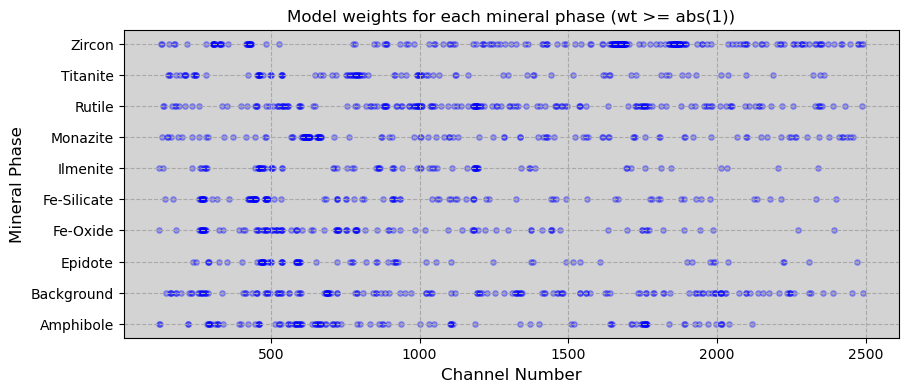

In [21]:
# Display the model weight contributions for each mineral above an arbitrary threshold (default=1)

# Create a binary dataframe where 1 represents values >= |1|
df_binary = (np.abs(df) >= 1).astype(int)
# Get the row names as strings
row_names = df.index.tolist()
# Create a list of (row_name, col_index) tuples for each value >= |1|
indices = [(row_names[i], j) for i in range(len(df)) for j in range(len(df.columns)) if df_binary.iloc[i, j] == 1]
# Extract row names and re-scale column indices
row_indices, col_indices = zip(*indices)
col_indices = [col + 120 for col in col_indices]

print("Figure 1. 10-mineral model weights")
# Create a dot plot of model weights for each mineral phase (channels weights only)
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_facecolor('lightgray')
plt.scatter(col_indices, row_indices, marker='o', s=15, c='blue', alpha=0.3)
plt.title("Model weights for each mineral phase (wt >= abs(1))")
plt.xlabel("Channel Number")
plt.ylabel("Mineral Phase")
plt.grid(color='darkgray', linestyle='--')
plt.savefig("G:/Modelling/IMAGES/weights.png")
plt.show()

#### 3.4.4 Evaluate the model

##### 3.4.4.1 Training data

##### Generate and export class predictions:

In [22]:
# Generate predictions on training using 3-fold cv (30 mins/10 minerals; 57mins/23 minerals)
# Note: if cv=int, estimator is a classifier and y is binary or multi-class, StratifiedKFold is used.
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=3, n_jobs=-1)

In [23]:
# Export predictions on the training set
np.savetxt("G:/Modelling/OUTPUTS/preds_train.csv", log_reg_pred, fmt="%s", delimiter=",")

In [24]:
log_reg_pred

array(['Zircon', 'Zircon', 'Monazite', ..., 'Amphibole', 'Background',
       'Zircon'], dtype='<U11')

##### Confusion Matrix and prediction metrics:

log_reg model on training


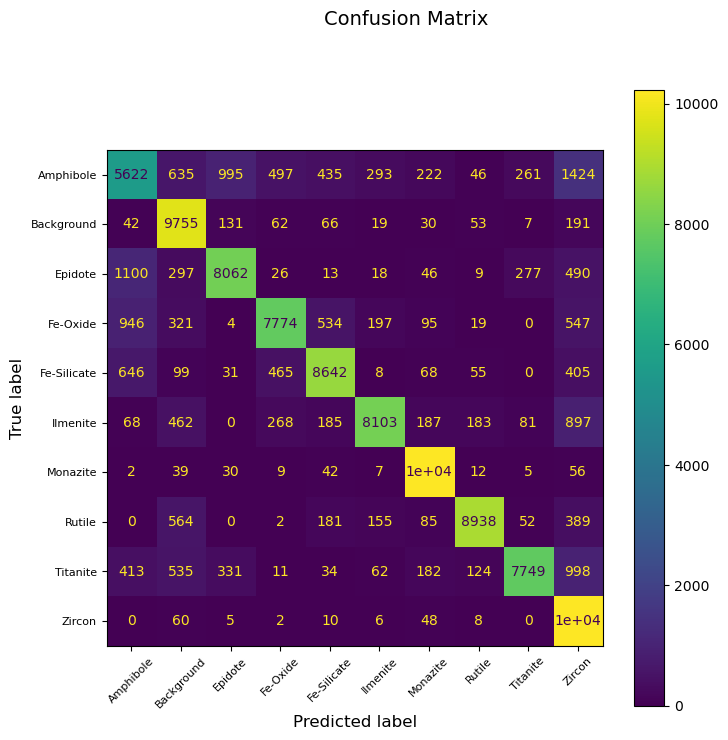

In [25]:
# Generate a confusion matrix
cm_log_reg_train = confusion_matrix(y_train, log_reg_pred)
print("log_reg model on training")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg_train,
                              display_labels=['Amphibole', 'Background', 'Epidote', 'Fe-Oxide', 'Fe-Silicate',
                                              'Ilmenite', 'Monazite', 'Rutile', 'Titanite', 'Zircon'])
# Plot the confusion matrix
disp.plot(colorbar=True)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)
# Set the rotation angle for x-labels
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.suptitle("Confusion Matrix", fontsize=14)
plt.savefig("G:/Modelling/IMAGES/cm_train.png")
plt.show()

In [26]:
# Report prediction results on training data
print("Prediction results on training data:\n")
print(classification_report(y_train, log_reg_pred, digits=2))

Prediction results on training data:

              precision    recall  f1-score   support

   Amphibole       0.64      0.54      0.58     10430
  Background       0.76      0.94      0.84     10356
     Epidote       0.84      0.78      0.81     10338
    Fe-Oxide       0.85      0.74      0.80     10437
 Fe-Silicate       0.85      0.83      0.84     10419
    Ilmenite       0.91      0.78      0.84     10434
    Monazite       0.91      0.98      0.95     10411
      Rutile       0.95      0.86      0.90     10366
    Titanite       0.92      0.74      0.82     10439
      Zircon       0.65      0.99      0.79     10370

    accuracy                           0.82    104000
   macro avg       0.83      0.82      0.82    104000
weighted avg       0.83      0.82      0.82    104000



##### Generate and export  prediction probabilities

In [27]:
# Generate prediction probabilities on training using 3-fold cv (~90 mins/10 minerals! (local); 58 mins/23 minerals)
# Note: for cv=int and estimator is a classifier and y is binary or multi-class, StratifiedKFold is used.
log_reg_proba = cross_val_predict(log_reg, X_train, y_train, cv=3, n_jobs=-1, method='predict_proba')

In [29]:
 # Export the probabilities array
np.savetxt("G:/Modelling/OUTPUTS/probs_train.csv", log_reg_proba, delimiter=",")

##### Display the average prediction probabilities for each mineral

In [30]:
# Convert the output probability array to a dataframe
probadf = pd.DataFrame(log_reg_proba, columns=list(log_reg.classes_))

In [31]:
# Function to find the column with the maximum value in a row
def find_max_column(row):
    max_col = row.idxmax()
    return pd.Series([max_col, row[max_col]], index=['Mineral Phase', 'Probability'])

In [32]:
# Apply the function row-wise to create new columns for every row
result = probadf.apply(find_max_column, axis=1)
# Display average prediction probability for each mineral class
result.groupby(['Mineral Phase'])['Probability'].mean()

Mineral Phase
Amphibole      0.939359
Background     0.986215
Epidote        0.897788
Fe-Oxide       0.940302
Fe-Silicate    0.956577
Ilmenite       0.983155
Monazite       0.984087
Rutile         0.978783
Titanite       0.978953
Zircon         0.982993
Name: Probability, dtype: float64

##### 3.4.4.2 Test data:

##### Generate and export class predictions and probabilities:

In [33]:
# Generate predictions on the test set
log_reg_test_pred = log_reg.predict(X_test)
np.savetxt("G:/Modelling/OUTPUTS/preds_test.csv", log_reg_test_pred, fmt="%s", delimiter=",")

In [34]:
log_reg_test_pred

array(['Epidote', 'Titanite', 'Background', ..., 'Epidote', 'Titanite',
       'Rutile'], dtype='<U11')

In [35]:
# Generate and export prediction probabilities on the test set
log_reg_test_proba = log_reg.predict_proba(X_test)
np.savetxt("G:/Modelling/OUTPUTS/probs_test.csv", log_reg_test_proba, delimiter=",")

In [36]:
log_reg_test_proba

array([[1.07406735e-002, 6.37420394e-135, 9.89259326e-001, ...,
        5.09654136e-080, 8.82182855e-023, 2.73666724e-132],
       [2.78834402e-050, 4.50951053e-095, 3.23705580e-024, ...,
        1.12003707e-065, 1.00000000e+000, 2.99288894e-072],
       [4.57325162e-030, 1.00000000e+000, 3.71283804e-034, ...,
        1.58361556e-067, 4.01240751e-058, 1.07027617e-083],
       ...,
       [4.99987879e-001, 3.22713830e-098, 5.00012121e-001, ...,
        3.02411334e-085, 1.27168161e-034, 5.78790326e-095],
       [1.56469718e-034, 1.15035430e-149, 1.69289207e-017, ...,
        2.59669051e-104, 1.00000000e+000, 1.33326214e-099],
       [6.08044167e-068, 4.87199144e-056, 1.74430267e-089, ...,
        1.00000000e+000, 1.94428998e-044, 4.06859843e-056]])

##### Confusion Matrix and prediction metrics:

log_reg model on test


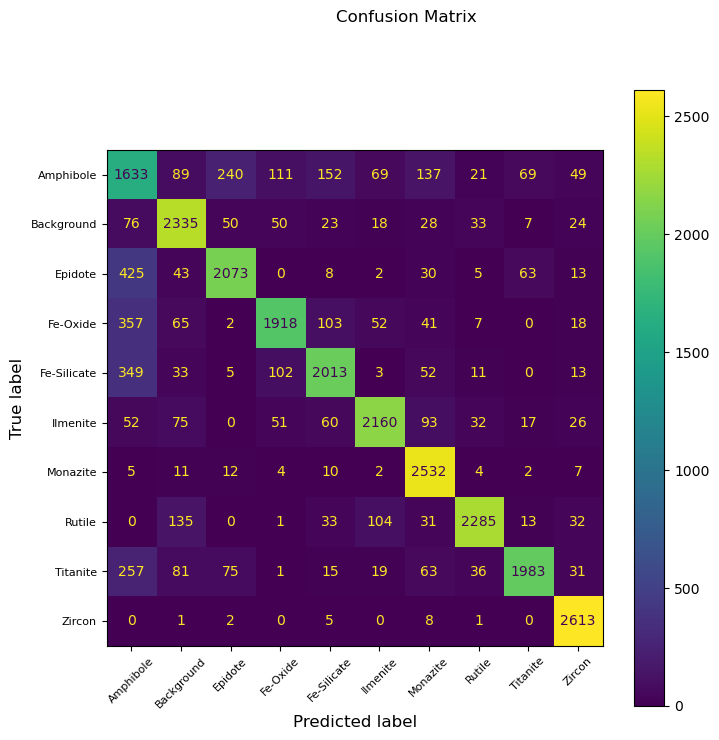

In [37]:
# Generate a confusion matrix
cm_log_reg_test = confusion_matrix(y_test, log_reg_test_pred)
print("log_reg model on test")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg_test,
                              display_labels=['Amphibole', 'Background', 'Epidote', 'Fe-Oxide', 'Fe-Silicate',
                                              'Ilmenite', 'Monazite', 'Rutile', 'Titanite', 'Zircon'])
# Plot the confusion matrix
disp.plot(colorbar=True)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.suptitle("Confusion Matrix")
plt.savefig("G:/Modelling/IMAGES/cm_test.png")
plt.show()

In [38]:
# Report prediction results on test data
print("Prediction results on test data:\n")
print(classification_report(y_test, log_reg_test_pred, digits=2))

Prediction results on test data:

              precision    recall  f1-score   support

   Amphibole       0.52      0.64      0.57      2570
  Background       0.81      0.88      0.85      2644
     Epidote       0.84      0.78      0.81      2662
    Fe-Oxide       0.86      0.75      0.80      2563
 Fe-Silicate       0.83      0.78      0.80      2581
    Ilmenite       0.89      0.84      0.86      2566
    Monazite       0.84      0.98      0.90      2589
      Rutile       0.94      0.87      0.90      2634
    Titanite       0.92      0.77      0.84      2561
      Zircon       0.92      0.99      0.96      2630

    accuracy                           0.83     26000
   macro avg       0.84      0.83      0.83     26000
weighted avg       0.84      0.83      0.83     26000



##### 3.4.4.3 Arbitrary unbalanced test data (trained minerals only):

In [39]:
# Load the arbitrary test set
arb_test = pd.read_csv("G:/Modelling/FINAL_PROCESSED/10_combined_shuffled_proc.csv")

In [40]:
arb_test.head()

,CH_121,CH_122,CH_123,CH_124,CH_125,CH_126,CH_127,CH_128,CH_129,CH_130,...,CH_2492,CH_2493,CH_2494,CH_2495,CH_2496,CH_2497,CH_2498,CH_2499,CH_2500,Mineral Phase
0,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,Background
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fe-Oxide
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,Background
3,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,Fe-Oxide
4,0,0,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,Background


In [41]:
# Check response category proportions
mineral_groups = arb_test.groupby('Mineral Phase').size()
mineral_groups

Mineral Phase
Amphibole      3984
Background     7000
Epidote        5193
Fe-Oxide       7000
Fe-Silicate    1229
Ilmenite       5808
Monazite        408
Rutile          611
Titanite       1768
Zircon          179
dtype: int64

In [42]:
 # Rename dataframe, call it X_arb
X_arb = arb_test
# Breakout the 'Mineral Phase'attribute and store in y (target)
y_arb = X_arb['Mineral Phase'].copy()
# Drop response attribute from X
X_arb.drop(columns=['Mineral Phase'], inplace=True)

In [43]:
# Standardize the arbitrary test set attributes
X_arb  = std_scaler.transform(X_arb) # Note: X_arb gets converted to an ndarray on output
print(f"Peak to Peak range by column in Standardized X_train: {np.ptp(X_train,axis=0)}")

Peak to Peak range by column in Standardized X_train: [10.9832803  12.33947936 13.46875396 ...  8.78153174  8.83133629
 11.72542966]


In [44]:
# Check the shape of all input arrays
print ('The shape of X_arb is:', X_arb.shape)
print ('The shape of y_arb is: ', y_arb.shape)
print ('Number of arb_test examples:', len(X_arb))


The shape of X_arb is: (33180, 2380)
The shape of y_arb is:  (33180,)
Number of arb_test examples: 33180


##### Generate class predictions and probabilities:

In [45]:
# Generate predictions on the arbitrary test set
log_reg_arb_pred = log_reg.predict(X_arb)
np.savetxt("G:/Modelling/OUTPUTS/preds_arb.csv", log_reg_arb_pred, fmt="%s", delimiter=",")

In [46]:
log_reg_arb_pred

array(['Background', 'Fe-Oxide', 'Background', ..., 'Background',
       'Monazite', 'Background'], dtype='<U11')

In [47]:
# Generate and export prediction probabilities on the arb_test set
log_reg_arb_proba = log_reg.predict_proba(X_arb)
np.savetxt("G:/Modelling/OUTPUTS/probs_arb.csv", log_reg_arb_proba, delimiter=",")

In [48]:
log_reg_arb_proba

array([[1.35345433e-040, 1.00000000e+000, 1.76217700e-035, ...,
        2.70643811e-016, 1.26826528e-038, 6.68307412e-132],
       [8.15364107e-030, 4.47075254e-082, 5.19920344e-068, ...,
        8.28843850e-096, 9.08332099e-133, 3.73487616e-070],
       [1.11395644e-046, 1.00000000e+000, 3.18102829e-051, ...,
        1.73389473e-081, 3.62838189e-056, 1.13052342e-057],
       ...,
       [2.77921805e-026, 1.00000000e+000, 9.37119946e-016, ...,
        2.05569680e-023, 4.65434103e-050, 1.26691791e-054],
       [8.66859788e-009, 2.37702637e-063, 2.39193717e-047, ...,
        3.47870197e-032, 1.58283472e-032, 5.72405891e-032],
       [7.41604548e-032, 1.00000000e+000, 8.67817616e-044, ...,
        2.59078927e-031, 9.98410650e-067, 2.61795038e-062]])

##### Confusion Matrix and prediction metrics:

log_reg model on arb_test


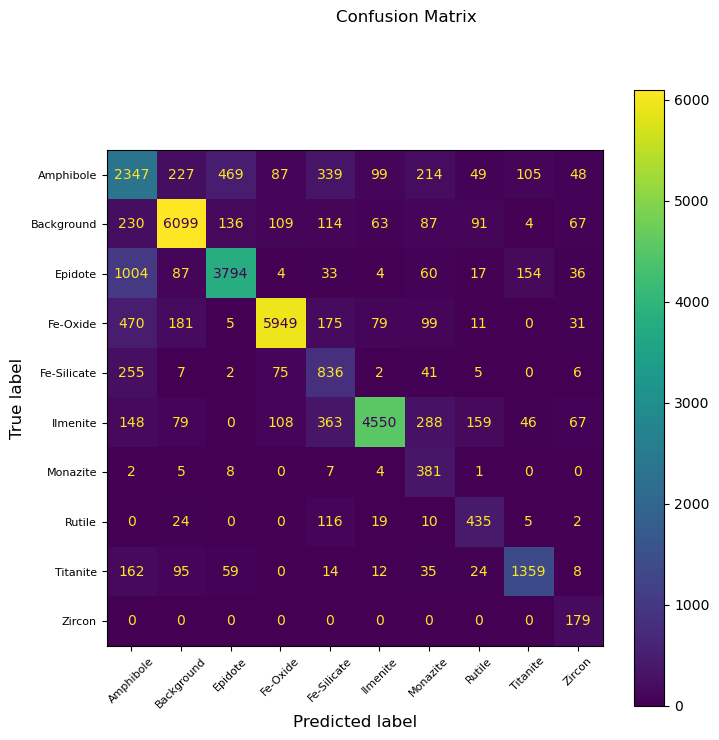

In [49]:
# Generate a confusion matrix
cm_log_reg_arb = confusion_matrix(y_arb, log_reg_arb_pred)
print("log_reg model on arb_test")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg_arb, display_labels=['Amphibole', 'Background',
                                              'Epidote', 'Fe-Oxide', 'Fe-Silicate', 'Ilmenite', 'Monazite',
                                              'Rutile', 'Titanite', 'Zircon'])
# Plot the confusion matrix
disp.plot(colorbar=True)
fig = disp.ax_.get_figure()
fig.set_figwidth(8)
fig.set_figheight(8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.suptitle("Confusion Matrix")
plt.savefig("G:/Modelling/IMAGES/cm_arb.png")
plt.show()

In [50]:
# Report prediction results on arb_test data
print("Prediction results on arb_test data:\n")
print(classification_report(y_arb, log_reg_arb_pred, digits=2))

Prediction results on arb_test data:

              precision    recall  f1-score   support

   Amphibole       0.51      0.59      0.55      3984
  Background       0.90      0.87      0.88      7000
     Epidote       0.85      0.73      0.79      5193
    Fe-Oxide       0.94      0.85      0.89      7000
 Fe-Silicate       0.42      0.68      0.52      1229
    Ilmenite       0.94      0.78      0.86      5808
    Monazite       0.31      0.93      0.47       408
      Rutile       0.55      0.71      0.62       611
    Titanite       0.81      0.77      0.79      1768
      Zircon       0.40      1.00      0.57       179

    accuracy                           0.78     33180
   macro avg       0.66      0.79      0.69     33180
weighted avg       0.82      0.78      0.79     33180



## 4. Discussion

Table 1 below juxtaposes the full classification performance metrics for each evaluation (training, test, unbalanced test). The model displayed very similar results on training and test data with an overall accuracy of ~82% indicating a robust model with no evidence of overfitting however did not perform to the same accuracy as more complex Random Forest and Deep Learning models developed by other team members. This was not unexpected. Despite lower accuracy, the strength of this model lay in is its simplicity, interpretability and transparency relative to more complex ‘black box’ models and was principal motivation for its construction.

As also observed by other team models, a drop in performance was seen on unbalanced test sets particular for minerals with low representation. For example, Monazite, Rutile and Zircon saw a significant reduction in precision while recall was far less affected - in fact Zircon returned a perfect score and Monazite still managed a high recall at 93%. This indicated that the model produced more false positives for those minerals while still maintaining its ability to accurately predict true positives, the latter being of prime importance for the client. A handful of minerals was seen to consistently return mediocre predictions by models across all data sets and the logistic regression model was no exception (e.g., Amphibole). The reason for this unknown and a topic for further investigation.

Apart from the lower accuracy achieved compared to other models, an obvious limitation of the model was that it was only capable of predicting 10 minerals. This however was mainly due to the memory and compute resources available and to some extent time constraints. (A 23 mineral model was constructed taking just under 1hr to train however hyperparameter tuning was not possible due to insufficient memory). Out-of-core or mini-batch learning is one way to avoid memory issues but was not implemented because training times were projected to be similar if not longer. That said, other team members were able to successfully implement incremental learning techniques for their models.

|               |           | training |          |         |           |  test  |          |         |           | test (u/b) |          |         |
|---------------|----------:|---------:|---------:|--------:|----------:|-------:|---------:|--------:|----------:|-----------:|---------:|--------:|
|               |           |          |          |         |           |        |          |         |           |            |          |         |
| Mineral Phase | precision |   recall | f1-score | support | precision | recall | f1-score | support | precision |     recall | f1-score | support |
|               |           |          |          |         |           |        |          |         |           |            |          |         |
|     Amphibole | 0.64      | 0.54     | 0.58     | 10430   | 0.52      | 0.64   | 0.57     | 2570    | 0.51      | 0.59       | 0.55     | 3984    |
|    Background | 0.76      | 0.94     | 0.84     | 10356   | 0.81      | 0.88   | 0.85     | 2644    | 0.90      | 0.87       | 0.88     | 7000    |
|       Epidote | 0.84      | 0.78     | 0.81     | 10338   | 0.84      | 0.78   | 0.81     | 2662    | 0.85      | 0.73       | 0.79     | 5193    |
|      Fe-Oxide | 0.85      | 0.74     | 0.80     | 10437   | 0.86      | 0.75   | 0.80     | 2563    | 0.94      | 0.85       | 0.89     | 7000    |
|   Fe-Silicate | 0.85      | 0.83     | 0.84     | 10419   | 0.83      | 0.78   | 0.80     | 2581    | 0.42      | 0.68       | 0.52     | 1229    |
|      Ilmenite | 0.91      | 0.78     | 0.84     | 10434   | 0.89      | 0.84   | 0.86     | 2566    | 0.94      | 0.78       | 0.86     | 5808    |
|      Monazite | 0.91      | 0.98     | 0.95     | 10411   | 0.84      | 0.98   | 0.90     | 2589    | 0.31      | 0.93       | 0.47     |  408    |
|        Rutile | 0.95      | 0.86     | 0.90     | 10366   | 0.94      | 0.87   | 0.90     | 2634    | 0.55      | 0.71       | 0.62     |  611    |
|      Titanite | 0.92      | 0.74     | 0.82     | 10439   | 0.92      | 0.77   | 0.84     | 2561    | 0.81      | 0.77       | 0.79     | 1768    |
|        Zircon | 0.65      | 0.99     | 0.79     | 10370   | 0.92      | 0.99   | 0.96     | 2630    | 0.40      | 1.00       | 0.57     |  179    |
|               |           |          |          |         |           |        |          |         |           |            |          |         |
| accuracy      |           |          | 0.82     | 104000  |           |        | 0.83     | 26000   |           |            | 0.78     | 33180   |
| macro avg     | 0.83      | 0.82     | 0.82     | 104000  | 0.84      | 0.83   | 0.83     | 26000   | 0.66      | 0.79       | 0.69     | 33180   |
| weighted avg  | 0.83      | 0.82     | 0.82     | 104000  | 0.84      | 0.83   | 0.83     | 26000   | 0.82      | 0.78       | 0.79     | 33180   |

Table 1: Classification performance for 10 mineral model on training, test and unbalanced test sets.

Figure 1 in section 3.4.3 displays a visualisation of the model weights extracted from the 10-mineral model. The weights represent the coefficients of the predictor variables on the scale of the linear predictor. The absolute magnitude of each coefficient is an indication of the strength of contribution of a predictor (in this case a particular channel count) to the predicted response of the model. The larger the magnitude of the coefficient, the greater the contribution. The graphic displays only those channels with weights above an arbitrary threshold (default=|1|). The intention is to  provide a visual indication of channels that are most/least useful to the identifcation of minerals.

In Section 3.4.4.1, average prediction probabilities are computed for each mineral and displayed. Specifically, these represent the prediction probabilites averaged over all positive predictions of that mineral in the training set and should be used with caution. Alternatively, the prediction probabilities for each mineral in each observation are output in bulk as a CSV file and should prove more useful. For example, if the maximum probability in an observation is found to be very low, say below 50%, that observation could be tagged for further investigation as an unknown mineral of potential interest.

## 5. Summary

A multinomial logistic regression model with L1 regularistion was constructed with the objective of rapidly, accurately and precisely identifying minerals from spectral energy channel counts derived from micro-XRF scanning of mineral grain samples. The model was an individual contribution by the author towards a joint effort by the UWA Data Science Capstone Project Group 8 team.

The nature of the supplied dataset posed significant challenges to model design and construction, particularly with regard to available compute and storage resources. As such, a decision was made to limit the scope of the final model to 10 classes instead of the full 51 for the purposes of this project.

The resulting model performed equally well on unseen test data as it did on the data it was trained on, returning an overall accuracy of ~83%, indicating the model was robust with no evidence of overfitting. A drop in performance was seen on unbalanced test data particularly for minerals with low representation. This was a common observation across all models evaluated by the team. Importantly, the model appeared to maintain its integrity with respect to accurately predicting true positives under these circumstances. One mineral (Amphibole) consistently returned mediocre scores for reasons which were unclear. Other models observed a similar result for this mineral. 

Although the model did not achieve the same level of accuracy as more complex models developed by the team, this was not entirely unexpected. Despite the lower accuracy, the strength of this model lay in its simplicity, interpretability and transparency. Conceptually, its intention from the outset was to serve as a 'baseline' robust proof-of-concept classifier capable of providing all the necessary outputs.